# Imports

In [3]:
import numpy as np
from sklearn.metrics import mean_squared_error
from collaborative_filtering import *
import pandas as pd
import time

# Define Data

In [14]:
item_user_matrix = np.array([
    [0,1,1,0,0],
    [2,3,1,0,2],
    [1,0,2,0,1],
    [0,4,3,2,0]
])

V = pd.DataFrame(item_user_matrix, columns=['Jim', 'Pam', 'Michael', 'Angela', 'Erin'], index=['Fruits', 'Vegetables', 'Coffee', 'Bread'])

In [15]:
V

,Jim,Pam,Michael,Angela,Erin
Fruits,0,1,1,0,0
Vegetables,2,3,1,0,2
Coffee,1,0,2,0,1
Bread,0,4,3,2,0


In [16]:
nmf = NMF(n_components=3).fit(item_user_matrix)
H = nmf.components_
W = nmf.transform(item_user_matrix)

In [17]:
reconstruct_H = pd.DataFrame(H, columns=['Jim', 'Pam', 'Michael', 'Angela', 'Erin'])
reconstruct_H

,Jim,Pam,Michael,Angela,Erin
0,0.027240,9.543848,0.000000,0.904880,0.027240
1,2.137091,0.098697,1.221059,0.000000,2.137091
2,0.000000,0.000000,1.739512,0.735176,0.000000


In [18]:
reconstructed_W = pd.DataFrame(W, index=['Fruits', 'Vegetables', 'Coffee', 'Bread'])
reconstructed_W

,0,1,2
Fruits,0.100281,0.023213,0.455221
Vegetables,0.302166,0.916377,0.000000
Coffee,0.000000,0.495681,0.680289
Bread,0.422063,0.000000,1.796809


In [19]:
np.dot(W, H)

array([[0.05234081, 0.9593575 , 0.82020749, 0.42540992, 0.05234081],
       [1.96661212, 2.9742665 , 1.11895058, 0.27342363, 1.96661212],
       [1.05931551, 0.04892206, 1.78862724, 0.50013245, 1.05931551],
       [0.01149697, 4.02810451, 3.12556993, 1.70288699, 0.01149697]])

# Recommender System with no Dim. Reduction

In [3]:
nmf_pred = nmf_wrapper(item_user_matrix)

In [4]:
mse = mean_squared_error(item_user_matrix, nmf_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.03623154133121916


# Recommender System with PCA

In [5]:
pred_nmf_pca = nmf_pca_wrapper(item_user_matrix)

In [6]:
mse = mean_squared_error(item_user_matrix, pred_nmf_pca)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1.46955501445551


# Recommender System Using LU_CRTP

In [7]:
pred = lu_crtp_wrapper(item_user_matrix)

In [8]:
mse = mean_squared_error(item_user_matrix, pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1.7315857487660493


# Test Loop

In [4]:
def read_file():
    data = []
    file_count = 0
    with open('dataset/combined_data_1.txt', 'r') as file:
        current_movie_id = None
        for line in file:
            line = line.strip() 
            if ':' in line:
                # The file contains movies and their raiting from users
                # if there is a : in a line, it indiactes we reached the next movie
                current_movie_id = line.split(':')[0] 
            else:
                # Else the line contains a user id and a rating
                if line:
                    user_id, rating, _ = line.split(',')
                    data.append({
                        'MovieID': current_movie_id,
                        'UserID': user_id,
                        'Rating': rating
                    })
            file_count += 1
            if file_count > 100000:
                break

    # Create dataframe and change datatypes
    df = pd.DataFrame(data)
    df['MovieID'] = df['MovieID'].astype(int)
    df['UserID'] = df['UserID'].astype(int)
    df['Rating'] = df['Rating'].astype(float)
    return df

# Read real data
movie_data = read_file()

In [5]:
# Change the structure to a user/item matrix
movie_data = movie_data.pivot(index='UserID', columns='MovieID', values='Rating')

# Fill NaN values
movie_data.fillna(value=0, inplace=True)

In [6]:
# result stores for real data
runtime_results_real = pd.DataFrame(columns=['n', 'method', 'result', 'k'])
mae_results_real = pd.DataFrame(columns=['n', 'method', 'result', 'k'])

In [7]:
# run real tests
for n in range(1000, 10001, 1000):
    item_user_matrix = movie_data[:n].to_numpy()
    orig_matrix = np.copy(item_user_matrix)
    n, m = item_user_matrix.shape
    
    
    # We should be dealing with a sparse matrix, so let's delete 60% of the values
    delete_count = int(n * m * 0.6)
    delete_idx = np.unravel_index(np.random.choice(n * m, delete_count, replace=False), item_user_matrix.shape)
    item_user_matrix[delete_idx] = 0

    for k in [3, 5, 7, 9]:
        for method, wrapper in zip(['NMF', 'NMF_PCA', 'LU_CRTP'], [nmf_wrapper, nmf_pca_wrapper, lu_crtp_wrapper]):
            begin = time.time()
            output = wrapper(item_user_matrix, n_components=k)
            runtime = time.time() - begin
            error = mean_squared_error(orig_matrix[delete_idx], output[delete_idx])
            mae_results_real.loc[len(mae_results_real)] = [n, method, error, k]
            runtime_results_real.loc[len(runtime_results_real)] = [n, method, runtime, k]

    print(f"=== Finished testing for size {n} ===")

# quicksave results
mae_results_real.to_csv('test_results/mae_real.csv')
runtime_results_real.to_csv('test_results/runtime_real.csv')

/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


=== Finished testing for size 1000 ===


/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


=== Finished testing for size 2000 ===


/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


=== Finished testing for size 3000 ===


/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


=== Finished testing for size 4000 ===


/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


=== Finished testing for size 5000 ===


/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


=== Finished testing for size 6000 ===


/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


=== Finished testing for size 7000 ===


/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


=== Finished testing for size 8000 ===


/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


=== Finished testing for size 9000 ===


/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


=== Finished testing for size 10000 ===


In [8]:
# result stores for rng data
runtime_results_rng = pd.DataFrame(columns=['n', 'method', 'result', 'k'])
mae_results_rng = pd.DataFrame(columns=['n', 'method', 'result', 'k'])

In [9]:
# run rng tests
for n in range(1000, 10001, 1000):
    item_user_matrix = np.random.randint(6, size=(n, n))
    orig_matrix = np.copy(item_user_matrix)
    
    # We should be dealing with a sparse matrix, so let's delete 60% of the values
    delete_count = int(n * n * 0.6)
    delete_idx = np.unravel_index(np.random.choice(n * n, delete_count, replace=False), item_user_matrix.shape)
    item_user_matrix[delete_idx] = 0

    for k in [3, 5, 7, 9]:
        for method, wrapper in zip(['NMF', 'NMF_PCA', 'LU_CRTP'], [nmf_wrapper, nmf_pca_wrapper, lu_crtp_wrapper]):
            begin = time.time()
            output = wrapper(item_user_matrix, n_components=k)
            runtime = time.time() - begin
            error = mean_squared_error(orig_matrix[delete_idx], output[delete_idx])
            mae_results_rng.loc[len(mae_results_rng)] = [n, method, error, k]
            runtime_results_rng.loc[len(runtime_results_rng)] = [n, method, runtime, k]

    print(f"=== Finished testing for size {n} ===")



/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


=== Finished testing for size 1000 ===


/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


=== Finished testing for size 2000 ===


/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


=== Finished testing for size 3000 ===


/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


=== Finished testing for size 4000 ===


/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


=== Finished testing for size 5000 ===


/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nico/VSCodeRepos/stl-implementation/stl-implementation/.conda/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


KeyboardInterrupt: 

In [11]:
# quicksave results
mae_results_rng.to_csv('test_results/mae_rng.csv')
runtime_results_rng.to_csv('test_results/runtime_rng.csv')

In [12]:
mae_results_rng['method'] = mae_results_rng['method'].astype('category')
runtime_results_rng['method'] = runtime_results_rng['method'].astype('category')

mae_results_real['method'] = mae_results_real['method'].astype('category')
runtime_results_real['method'] = runtime_results_real['method'].astype('category')

In [16]:
import matplotlib.pyplot as plt

colors = ['red', 'green', 'blue']

def plot_runtime(plot_data, type='real'):
    for k in plot_data['k'].unique():
        _, ax = plt.subplots(figsize=(12, 6))
        k_subset = plot_data[plot_data['k'] == k]

        for i, method in enumerate(k_subset['method'].cat.categories):
            method_subset = k_subset[k_subset['method'] == method]
            ax.plot(method_subset['n'], method_subset['result'], marker='o', label=method, c=colors[i])

        plt.xlabel('Size of matrix', fontsize=18)
        plt.ylabel('Runtime [s]', fontsize=18)
        plt.legend()
        plt.grid(True, axis='y')

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_ylim(0)
        ax.set_xlim(1000)

        plt.savefig(f'figures/cf_runtime_{type}_{k}.png')
        plt.show()

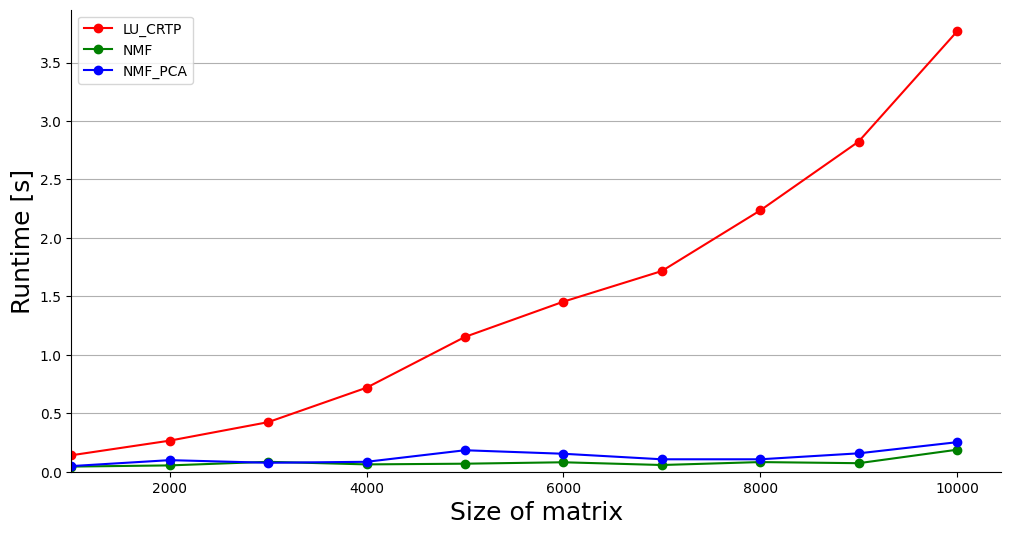

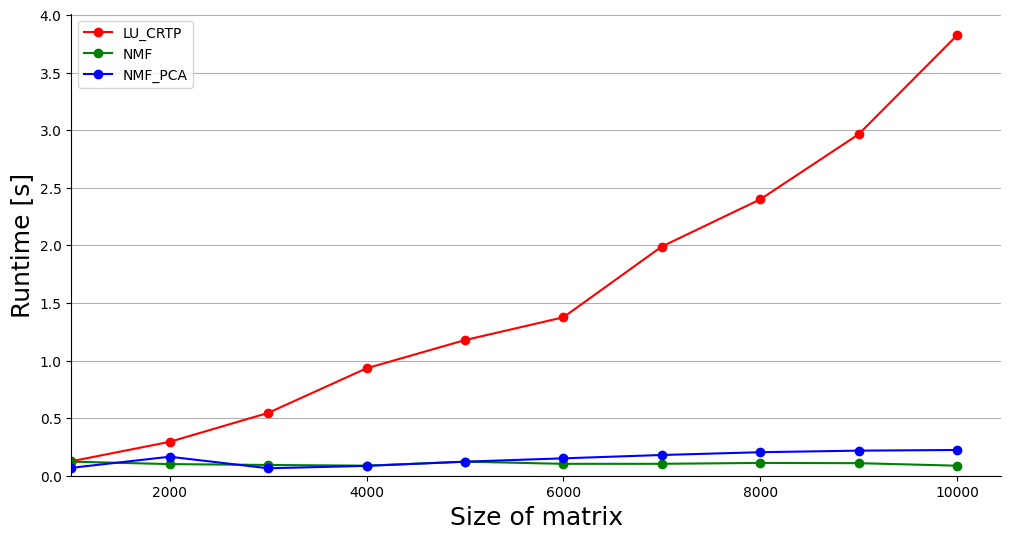

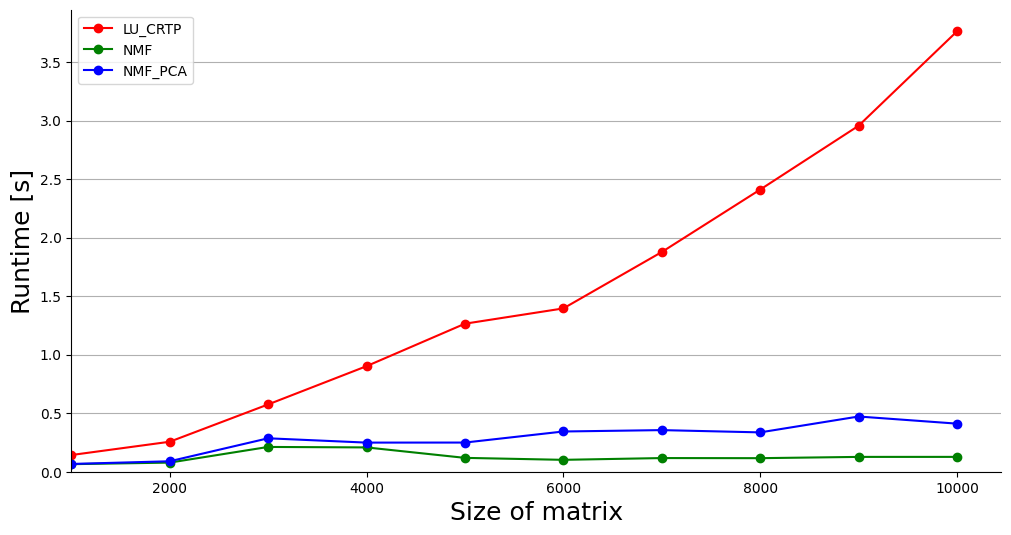

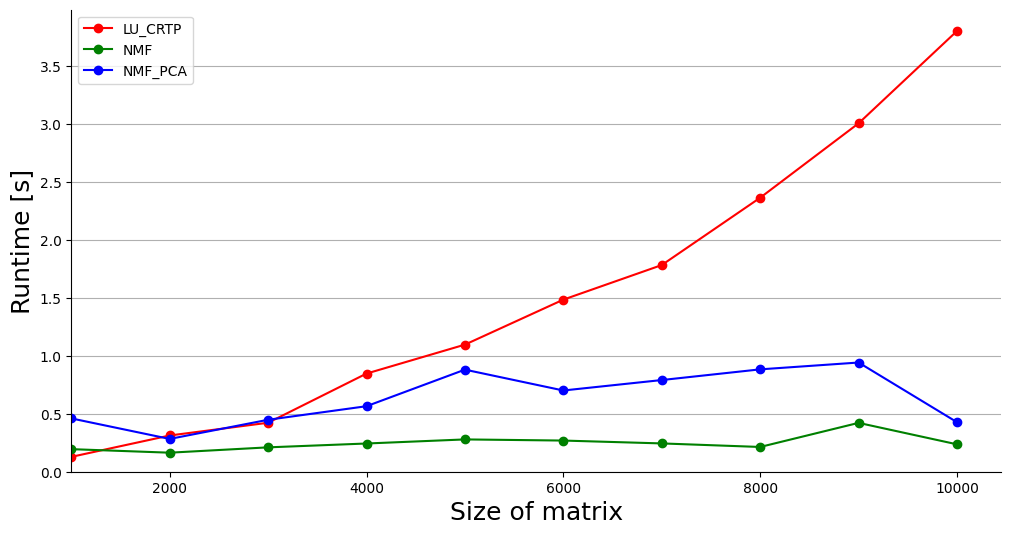

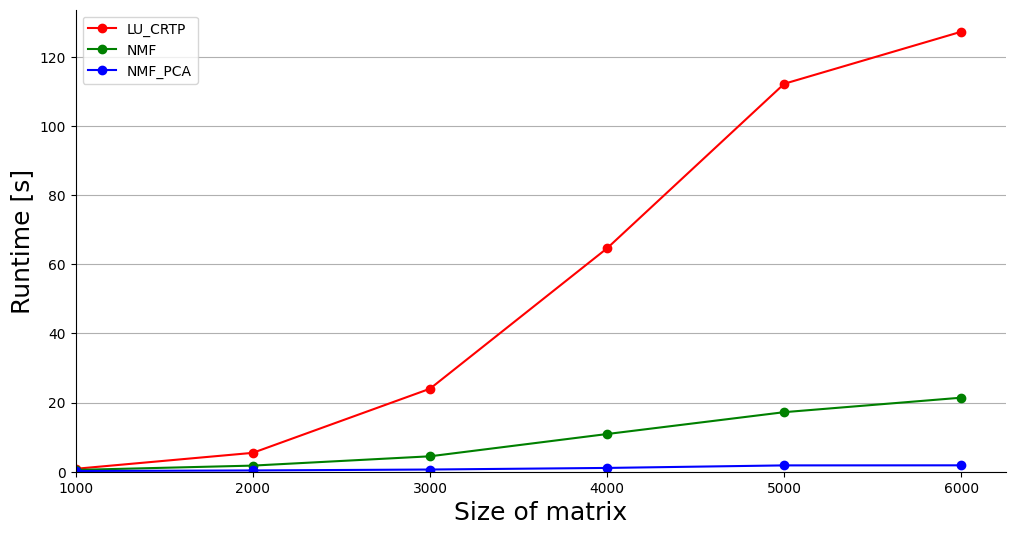

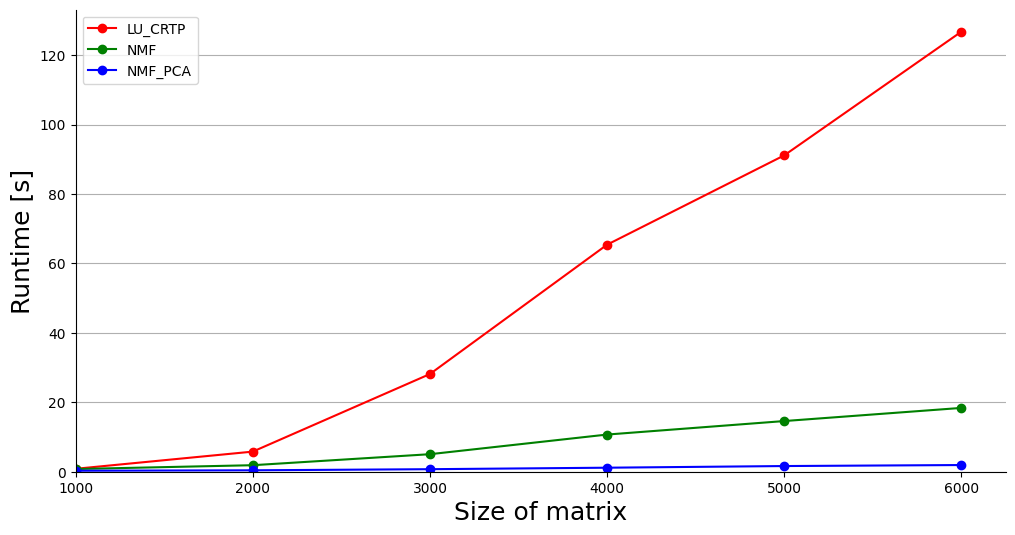

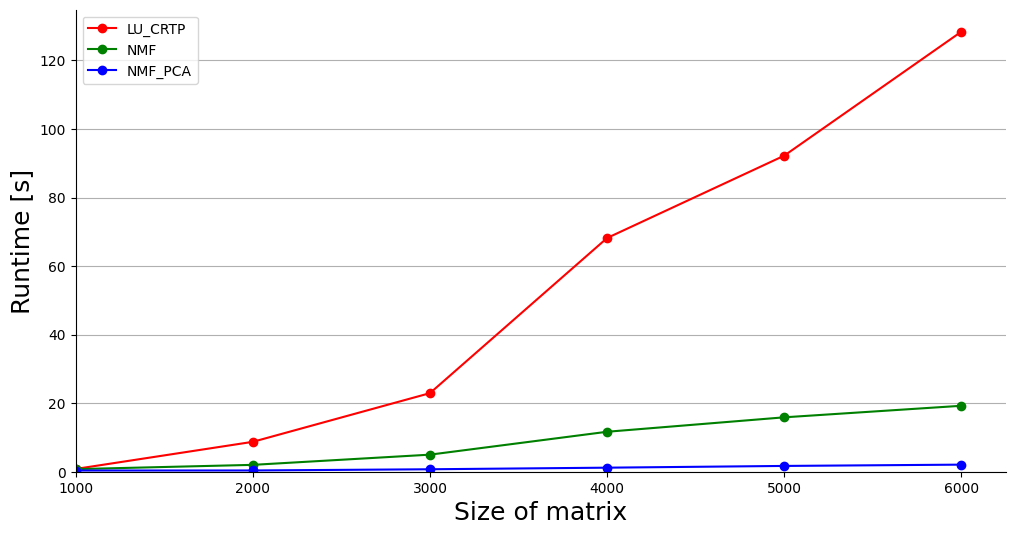

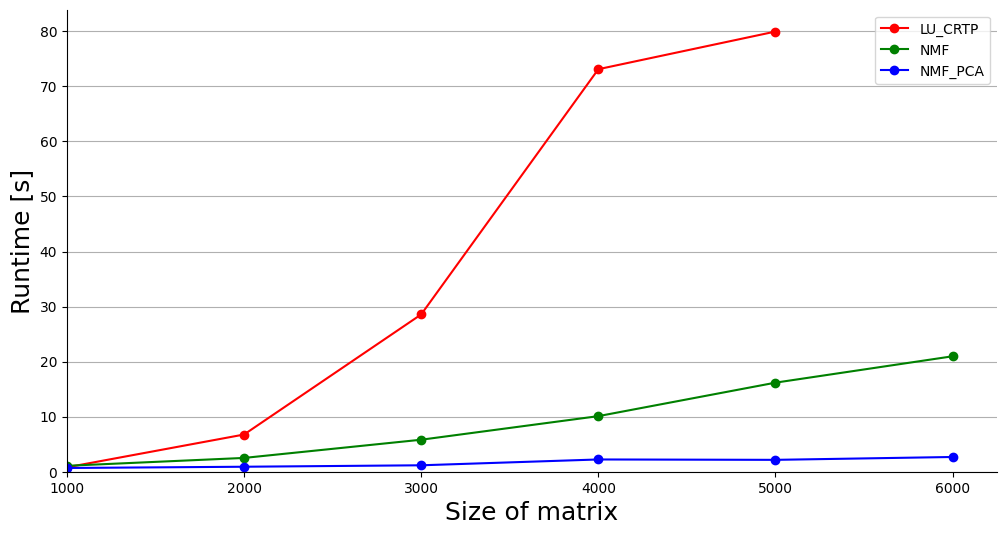

In [17]:
plot_runtime(runtime_results_real, 'real')
plot_runtime(runtime_results_rng, 'rng')

In [18]:
colors = ['red', 'green', 'blue']

def plot_mae(plot_data, type='real'):
    for k in plot_data['k'].unique():
        fig, ax = plt.subplots(figsize=(12, 6))
        k_subset = plot_data[plot_data['k'] == k]

        for i, method in enumerate(k_subset['method'].cat.categories):
            method_subset = k_subset[k_subset['method'] == method]
            ax.plot(method_subset['n'], method_subset['result'], marker='o', label=method, c=colors[i])

        plt.xlabel('Size of matrix', fontsize=16)
        plt.ylabel('MSE', fontsize=16)
        plt.legend()
        plt.grid(True, axis='y')

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_ylim(0)
        ax.set_xlim(1000)

        plt.savefig(f'figures/cf_mae_{type}_{k}.png')
        plt.show()

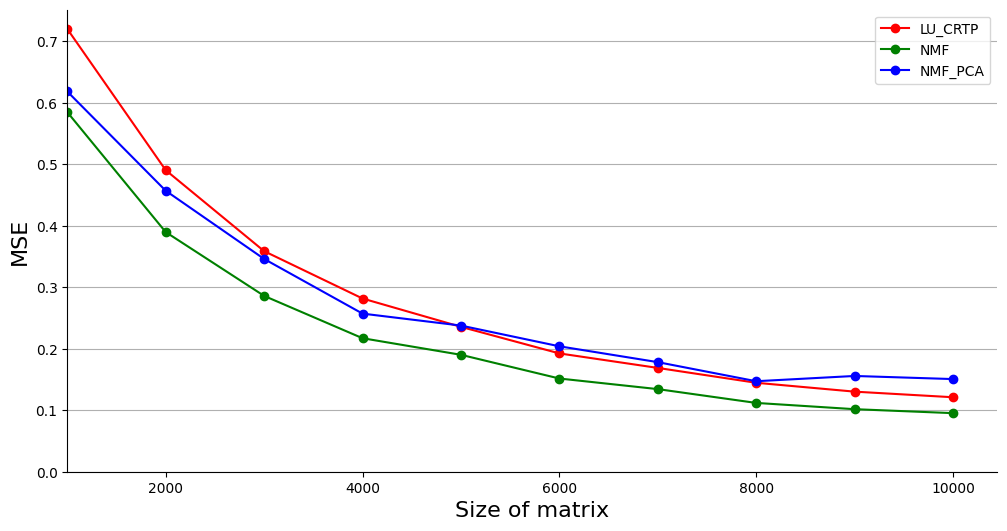

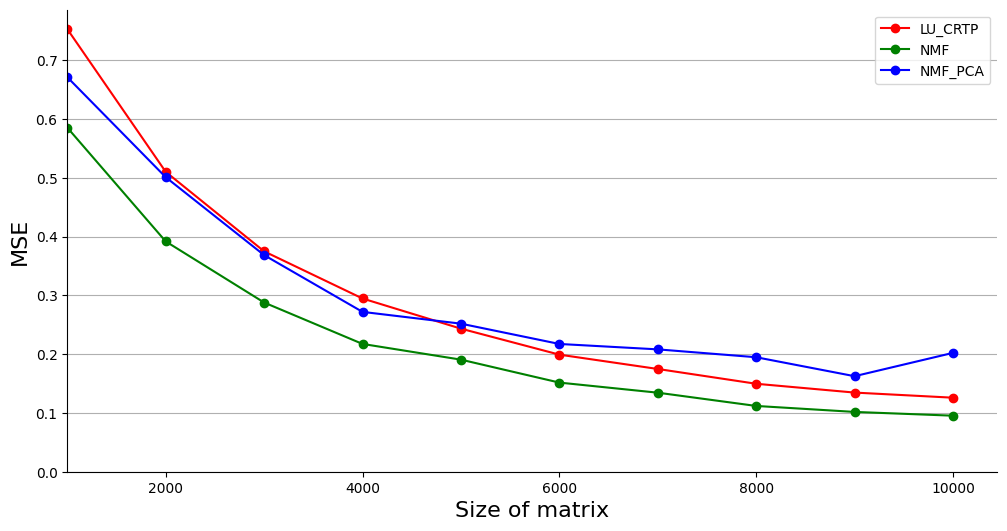

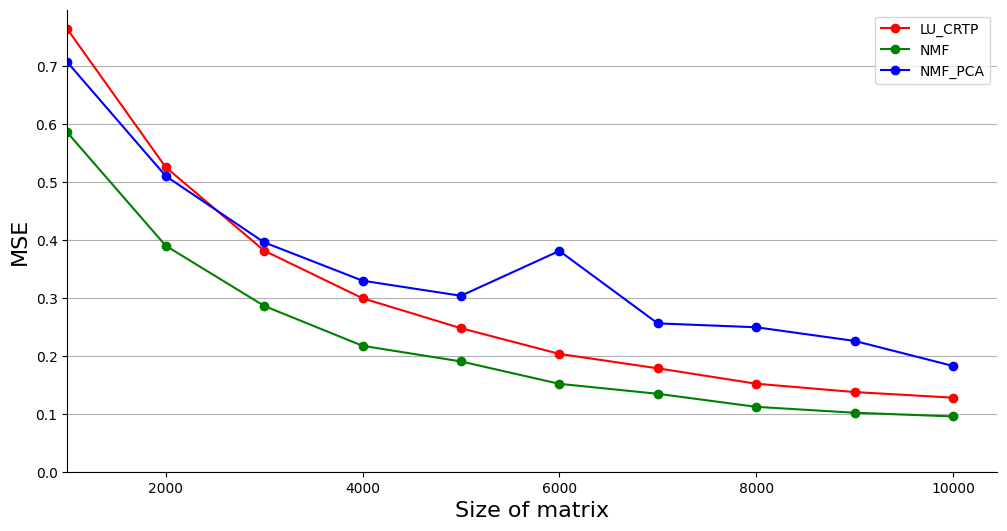

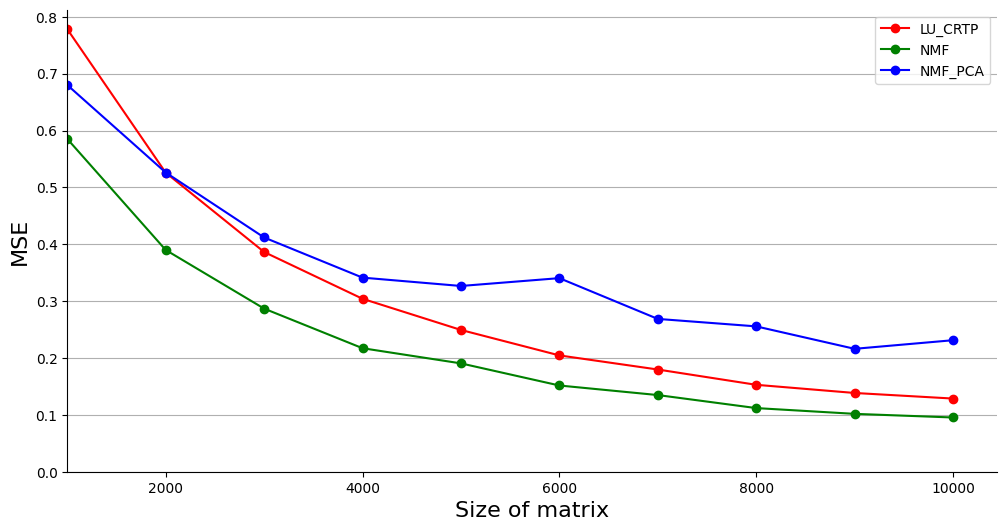

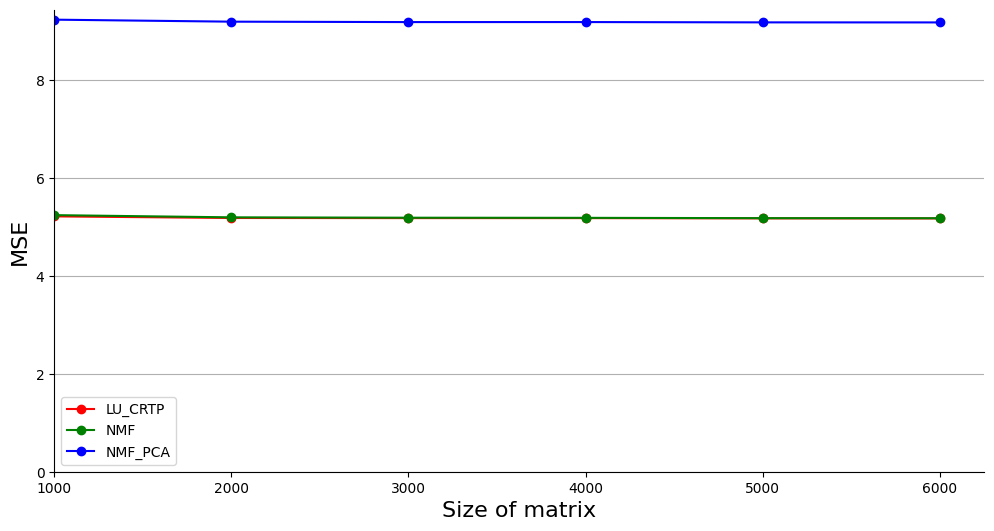

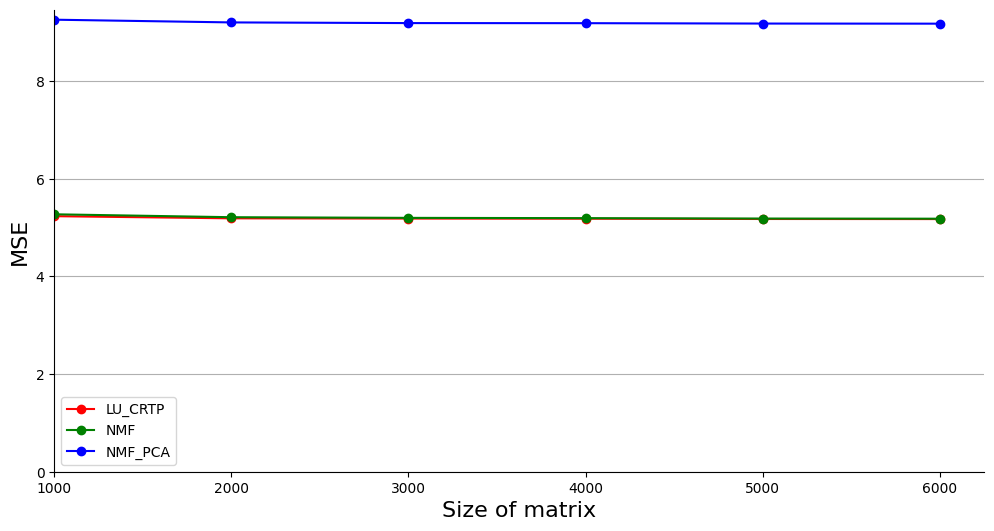

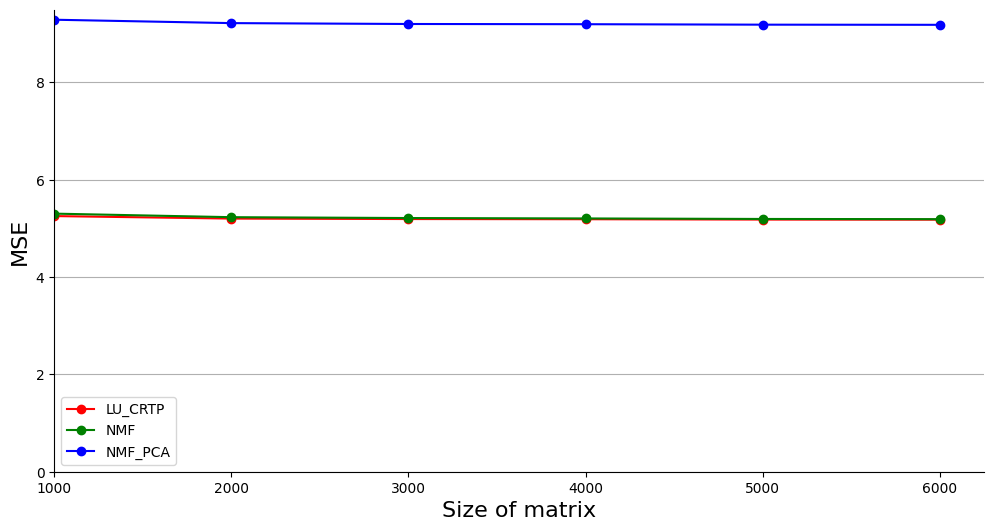

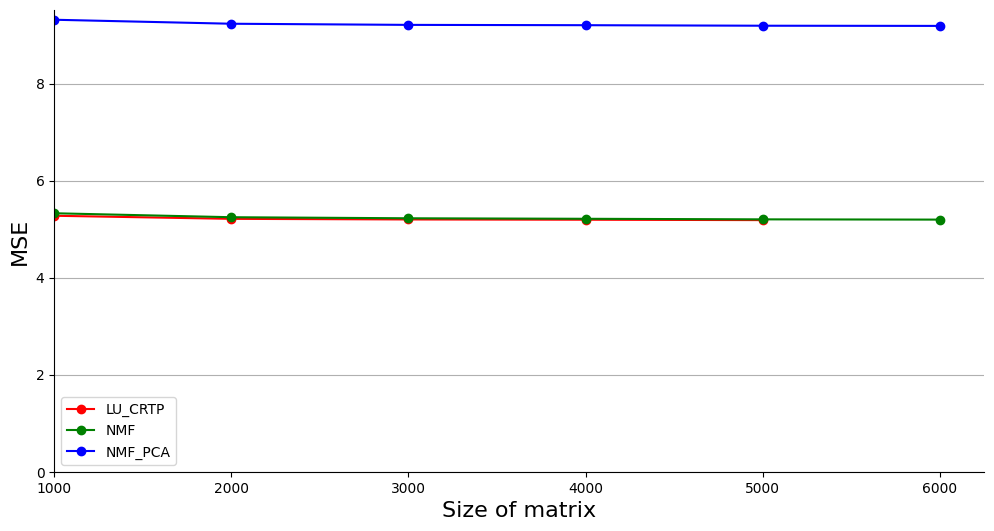

In [19]:
plot_mae(mae_results_real, 'real')
plot_mae(mae_results_rng, 'rng')